In [1]:
import json, os, sys, random, re
sys.path.append("../scripts/formalism")
from entropy import *
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from pprint import pprint
from textblob import Word
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import spacy  
nlp = spacy.load("en_core_web_lg") 

In [3]:
J = json.load(open("../data/nocaps/nocaps_val_4500_captions.json", "r"))
annotations, image_info = J['annotations'], J['images']
print("#captions = ", len(annotations))

#captions =  45000


In [4]:
image_info[0]

{'height': 1024,
 'file_name': '0013ea2087020901.jpg',
 'width': 732,
 'coco_url': 'https://s3.amazonaws.com/nocaps/val/0013ea2087020901.jpg',
 'open_images_id': '0013ea2087020901',
 'id': 0,
 'license': 0,
 'domain': 'in-domain',
 'date_captured': '2018-11-06 11:04:33'}

In [10]:
### Download all images

# urls = set([i['coco_url'] for i in image_info])
# print(len(urls))
# for u in tqdm(urls):
#     os.system(f"wget -q {u} -P /data/yingshac/clevr_control/data/nocaps/images/")

4500


100%|██████████| 4500/4500 [20:51<00:00,  3.59it/s]


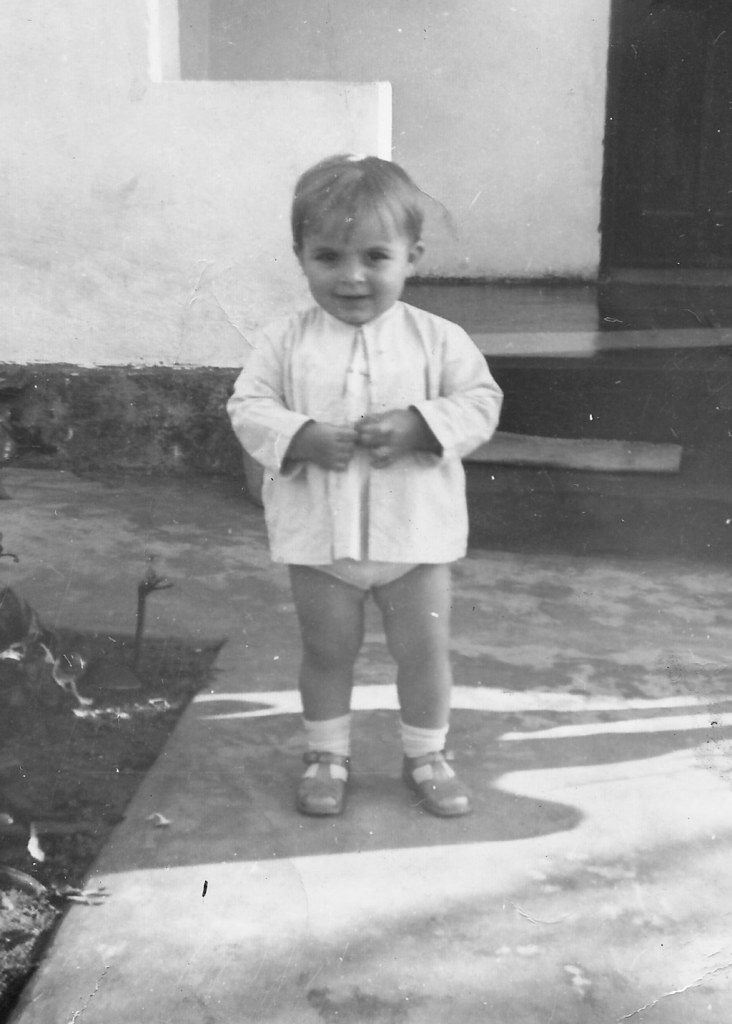

In [6]:
im = Image.open(f"/data/yingshac/clevr_control/data/nocaps/0013ea2087020901.jpg")
im

In [11]:
annotations[10]

{'image_id': 1,
 'id': 10,
 'caption': "An elephant standing in front of a tree, wearing a saddle on it's back."}

In [4]:
positional_rel_v = ["below", "beneath", "under", "at the bottom of", "above", "on top of", "on"]
positional_rel_h = ["to the left of", "to the right of"]
positional_rel_fb = ["in front of", "behind"]

In [5]:
def preprocess(text):
    text = text.replace(",", " ,")
    text = " ".join(text.strip().split())
    return text

In [6]:
def extract_tuple(text, r):
    if not f" {r} " in text: return None
    # Doesn't inform a top-bottom relationship
    if r == "on" and any(b in text for b in ["on the side of", "on side", "on top.", "on the top."]): return None
    doc = nlp(text)

    # figure out pos_id of r
    # locate substring
    rs_idx = text.find(f" {r} ")+1
    re_idx = rs_idx + len(f"{r} ")
    tokens = [token for token in doc]
    for i, token in enumerate(tokens):
        if token.idx == rs_idx: rs = i
        elif token.idx == re_idx: re = i
    
    #token_texts = [token.text for token in doc]
    #token_pos_ = [token.pos_ for token in doc]
    #token_dep_ = [token.dep_ for token in doc]
    subj, obj = "", ""

    for tok in tokens:
        if tok.head.i == re-1 and tok.pos_ == "NOUN": 
            obj = tok
    
    if obj == "": return None
    # handle "a set/pair of ___"
    # add "nummod" to handle "two sets of ____"
    if set(["det", "prep"]).issubset(set([a.dep_ for a in obj.children])) or set(["nummod", "prep"]).issubset(set([a.dep_ for a in obj.children])):
        of_tok = [a for a in obj.children if a.dep_ == "prep"][0]
        if of_tok.text == "of":
            of_children = [a for a in of_tok.children]
            if len(of_children): obj = of_children[0].text
    if not isinstance(obj, str): obj = obj.text  

    if tokens[rs].head.pos_ == "NOUN": subj = tokens[rs].head
    else:
        target_i = tokens[rs].head.i
        if tokens[rs].dep_ == "ROOT": # find the closest NOUN prior to the ROOT
            for i in range(rs-1, 0, -1):
                if tokens[i].pos_ == "NOUN":
                    subj = tokens[i]
        else:
            for tok in tokens:
                if tok.head.i == target_i and tok.pos_ == "NOUN":
                    subj = tok
            if len(subj) == 0:
                for i in range(rs-1, 0, -1):
                    if tokens[i].pos_ == "NOUN": subj = tokens[i]

    
    if subj == "": return None
    # handle "a set/pair of ___"
    # add "nummod" to handle "two sets of ____"
    if set(["det", "prep"]).issubset(set([a.dep_ for a in subj.children])) or set(["nummod", "prep"]).issubset(set([a.dep_ for a in subj.children])):
        of_tok = [a for a in subj.children if a.dep_ == "prep"][0]
        if of_tok.text == "of":
            of_children = [a for a in of_tok.children]
            if len(of_children): subj = of_children[0].text
    if not isinstance(subj, str): subj = subj.text     
    """
    look_for = {"ROOT": None, "dobj": None, "nsubj": None, "pobj": None}
    for i in range(rs-1, 0, -1):
        if token_pos_[i] == "NOUN" and token_dep_[i] in look_for and look_for[token_dep_[i]] is None:
            look_for[token_dep_[i]] = tokens[i]            
    for k in look_for:
        if look_for[k] is not None: 
            subj = look_for[k]
            break

    look_for = {"ROOT": None, "dobj": None, "nsubj": None, "pobj": None}
    for i in range(re, len(tokens)):
        if token_pos_[i] == "NOUN" and token_dep_[i] in look_for:
            obj = tokens[i]
            break
    if len(subj)*len(obj) == 0: 
        print(text)
        #return None
    """
    tuple = (subj, obj, r)

    # remove edge cases
    if obj == "top": return None # "A piece of pie with meringue on top has a flaky crust and pumpkin for filling"
    if subj == "side" or obj == "side": return None # "An Olympus Tough TG-310 camera sitting on it's side in front of the box.", "A white , gas stove with light tan counter tops on each side."
    if subj == "display" or obj == "display": return None # "statues of nude cupids on display in front of a window", "A group of people walk around a room full of new cars on display."
    return tuple 

In [130]:
for t in texts:
    text = preprocess(t)
    # order of positional phrases matters
    # if "on top of" is recognized, then don't process "on"
    for r in positional_rel_h + positional_rel_fb + positional_rel_v:
        if f" {r} " in text:
            print(text, extract_tuple(text, r))

Two sets of power plugs are on this socket as well as a switch. ('plugs', 'socket', 'on')
Two plastic objects that look like the caps you put on the end of turkey legs next to two sets of feet. ('objects', 'legs', 'on')
A man wearing a kilt has a set of bag pipes standing on the end of the steps. ('man', 'steps', 'on')
A bunch of leaves sit on the shelf above the carrots. ('shelf', 'carrots', 'above')
A bunch of leaves sit on the shelf above the carrots. ('leaves', 'shelf', 'on')


In [10]:
D = defaultdict(list)
for a in tqdm(annotations):
    for positional_relations in [positional_rel_h, positional_rel_fb, positional_rel_v]:
        for r in positional_relations:
            if f" {r} " in a['caption']:
                text = preprocess(a['caption'])
                tuple = extract_tuple(text, r)

                if tuple is not None:
                    D[r].append((a['image_id'], text, tuple))
                    break
for k in D:
    print(k, len(D[k]))
print("#instances = ", sum([len(D[k]) for k in D]))

100%|██████████| 45000/45000 [01:04<00:00, 699.06it/s]

in front of 1460
on 11685
above 166
on top of 554
under 269
behind 394
below 30
beneath 8
at the bottom of 14
to the right of 2
to the left of 1
#instances =  14583


In [12]:
print("#unique images = ", len(set([x[0] for k in D for x in D[k]])))
print("#unique captions = ", len(set([x[1] for k in D for x in D[k]])))
print("#unique concepts = ", len(set([x[2][0] for k in D for x in D[k]] + [x[2][1] for k in D for x in D[k]])))

#unique images =  3827
#unique captions =  14241
#unique concepts =  2975


In [11]:
json.dump(D, open("../data/nocaps/tmp.json", "w"), indent=4)

### Draft

In [7]:
from spacy import displacy


In [122]:
texts = [
        "Two sets of power plugs are on this socket as well as a switch.", 
        "Two plastic objects that look like the caps you put on the end of turkey legs next to two sets of feet.",
        "A man wearing a kilt has a set of bag pipes standing on the end of the steps.",
        "A bunch of leaves sit on the shelf above the carrots.",
]
for t in texts:
    text = preprocess(t)
    doc = nlp(text)
    displacy.render(doc, style="dep", jupyter=True, options={"distance":100})
    #print(text)
    #for token in doc: 
    #    print(token, token.pos_, token.tag_, token.dep_) 

In [123]:
for t in texts:
    text = preprocess(t)
    doc = nlp(text)
    print(text)
    for token in doc: 
        print(token.i, token, token.pos_, token.tag_, token.dep_, token.head.i, [a for a in token.children]) 
    print()

Two sets of power plugs are on this socket as well as a switch.
0 Two NUM CD nummod 1 []
1 sets NOUN NNS nsubj 5 [Two, of]
2 of ADP IN prep 1 [plugs]
3 power NOUN NN compound 4 []
4 plugs NOUN NNS pobj 2 [power]
5 are AUX VBP ROOT 5 [sets, on, .]
6 on ADP IN prep 5 [socket]
7 this DET DT det 8 []
8 socket NOUN NN pobj 6 [this, as, switch]
9 as ADV RB advmod 11 []
10 well ADV RB advmod 11 []
11 as ADP IN cc 8 [as, well]
12 a DET DT det 13 []
13 switch NOUN NN conj 8 [a]
14 . PUNCT . punct 5 []

Two plastic objects that look like the caps you put on the end of turkey legs next to two sets of feet.
0 Two NUM CD nummod 2 []
1 plastic ADJ JJ amod 2 []
2 objects NOUN NNS ROOT 2 [Two, plastic, look, .]
3 that PRON WDT nsubj 4 []
4 look VERB VBP relcl 2 [that, like]
5 like ADP IN prep 4 [caps]
6 the DET DT det 7 []
7 caps NOUN NNS pobj 5 [the, put]
8 you PRON PRP nsubj 9 []
9 put VERB VBD relcl 7 [you, on]
10 on ADP IN prep 9 [end]
11 the DET DT det 12 []
12 end NOUN NN pobj 10 [the, of, next]

### Characterize Entropies

In [13]:
entropy_funcs = [
    # "concept_centric_entropy3(num_nouns, num_relations, df)",
    # "concept_centric_entropy4(num_nouns, num_relations, df)",
    # "concept_centric_entropy5(num_nouns, num_relations, df)",
    # "relation_centric_entropy3(num_nouns, num_relations, df)",
    # "relation_centric_entropy4(num_nouns, num_relations, df)",
    # "relation_centric_entropy5(num_nouns, num_relations, df)",
    # "divergence(num_nouns, num_relations, df)",
    # "divergence2(num_nouns, num_relations, df)",
    # "divergence3(num_nouns, num_relations, df)",
    # "concept_role_entropy(num_nouns, df)",
    # "concept_role_entropy2(num_nouns, df)",
    # "role_association(num_nouns, df)",
    # "role_association2(num_nouns, df)",
    # "concept_entropy(num_nouns, df)",
    # "concept_entropy2(num_nouns, df)",
    # "concept_entropy0(num_nouns, df)",
    "concept_role_index_entropy(num_nouns, df)"
]

In [14]:
extracted_tuples = json.load(open("../data/nocaps/tmp.json", "r"))
for r in extracted_tuples:
    print(r, len(extracted_tuples[r]))
print(f"#Total instances with successful SPO parsing = {sum([len(v) for k, v in extracted_tuples.items()])}")


in front of 1460
on 11685
above 166
on top of 554
under 269
behind 394
below 30
beneath 8
at the bottom of 14
to the right of 2
to the left of 1
#Total instances with successful SPO parsing = 14583


### Front-Behind

In [17]:
SUBJ, OBJ = [], []
tuples, images, captions = [], [], []
for r in extracted_tuples:
    if not r in positional_rel_fb: continue
    
    for a in extracted_tuples[r]:
        subj, obj, _ = a[-1]
        #singularize
        singlular_subj = Word(subj).lemmatize()
        if not singlular_subj == False: subj = singlular_subj
        singlular_obj = Word(obj).lemmatize() 
        if not singlular_obj == False: obj = singlular_obj

        SUBJ.append(subj)
        OBJ.append(obj)
        tuples.append((subj, obj, r))
        captions.append(a[1])
        images.append(a[0])

print("#unique subjects = ", len(set(SUBJ)))
print("#unique objects = ", len(set(OBJ)))
nouns = sorted(list(set(SUBJ).union(set(OBJ))))
num_nouns = len(nouns)
print("#unique concepts = ", num_nouns)
num_relations = len(positional_rel_fb)
print("#instances = ", len(tuples))
print("#unique instances = ", len(set(tuples)))
print("#unique images = ", len(set(images)))
print("#unique captions = ", len(set(captions)))

n2i = {n:i for i, n in enumerate(nouns)}
r2i = {r:i for i, r in enumerate(positional_rel_fb)}
print(len(r2i), len(n2i))


#unique subjects =  498
#unique objects =  396
#unique concepts =  703
#instances =  1854
#unique instances =  1365
#unique images =  1051
#unique captions =  1854
2 703


In [22]:
transpose = False

train_triplets = [] # convert tuple elements to indices

for subj, obj, r in tuples:
    train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
if transpose: train_triplets = Transpose(train_triplets)

df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])

print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
for f in entropy_funcs:
    score = eval(f)
    print(f.split("(")[0], ": ", score, f"({round(score/np.log(2), 2)})") 

role intrinsic meanings: linguistic position

concept_role_index_entropy :  0.3110755296303216 (0.45)


In [23]:
print("role intrinsic meanings: {} position\nA set of complete objects:".format("image" if transpose else "linguistic"))
tmp1, tmp2 = set([t[0] for t in train_triplets]), set([t[1] for t in train_triplets])
cpl1, cpl2 = len(tmp1)/num_nouns, len(tmp2)/num_nouns
complete = tmp1.intersection(tmp2)
print(f"CPL(r1) = {round(cpl1, 2)}, CPL(r2) = {round(cpl2, 2)}, avg = {round((cpl1+cpl2)/2, 2)}")
print(complete)
print(len(complete))

role intrinsic meanings: linguistic position
A set of complete objects:
CPL(r1) = 0.71, CPL(r2) = 0.56, avg = 0.64
{519, 520, 521, 524, 530, 532, 534, 539, 28, 29, 541, 31, 542, 543, 554, 44, 47, 48, 49, 559, 561, 52, 56, 57, 571, 574, 65, 66, 67, 68, 69, 579, 71, 72, 583, 585, 592, 82, 594, 85, 86, 87, 601, 91, 93, 94, 95, 96, 607, 609, 101, 615, 104, 617, 107, 109, 621, 113, 627, 628, 117, 118, 119, 120, 123, 635, 125, 126, 131, 644, 133, 134, 135, 646, 648, 138, 139, 651, 142, 143, 654, 145, 657, 148, 660, 151, 665, 155, 670, 159, 160, 162, 676, 168, 169, 170, 680, 181, 694, 183, 695, 697, 698, 188, 190, 197, 200, 201, 206, 214, 215, 217, 226, 227, 231, 233, 238, 239, 244, 246, 248, 251, 254, 256, 257, 258, 259, 261, 265, 266, 267, 273, 275, 279, 280, 284, 288, 290, 293, 300, 303, 311, 316, 319, 321, 326, 327, 328, 334, 336, 341, 343, 347, 357, 362, 364, 369, 371, 374, 376, 379, 380, 383, 386, 396, 400, 409, 424, 425, 426, 428, 430, 431, 433, 436, 438, 440, 443, 445, 447, 448, 460, 

In [24]:
# complete nouns under linguistic positions
a = [28, 29, 31, 44, 47, 48, 49, 52, 56, 57, 65, 66, 67, 68, 69, 71, 72, 82, 85, 86, 87, 91, 93, 94, 95, 96, 101, 104, 107, 109, 113, 117, 118, 119, 120, 123, 125, 126, 131, 133, 134, 135, 138, 139, 142, 143, 145, 148, 151, 155, 159, 160, 162, 168, 169, 170, 181, 183, 188, 190, 197, 200, 201, 206, 214, 215, 217, 226, 227, 231, 233, 238, 239, 244, 246, 248, 251, 254, 256, 257, 258, 259, 261, 265, 266, 267, 273, 275, 279, 280, 284, 288, 290, 293, 300, 303, 311, 316, 319, 321, 326, 327, 328, 334, 336, 341, 343, 347, 357, 362, 364, 369, 371, 374, 376, 379, 380, 383, 386, 396, 400, 409, 424, 425, 426, 428, 430, 431, 433, 436, 438, 440, 443, 445, 447, 448, 460, 463, 465, 473, 474, 478, 483, 489, 500, 501, 519, 520, 521, 524, 530, 532, 534, 539, 541, 542, 543, 554, 559, 561, 571, 574, 579, 583, 585, 592, 594, 601, 607, 609, 615, 617, 621, 627, 628, 635, 644, 646, 648, 651, 654, 657, 660, 665, 670, 676, 680, 694, 695, 697, 698]
print(len(a))
# complete nouns under image positions
b = [7, 9, 28, 29, 31, 33, 40, 41, 44, 45, 47, 48, 49, 51, 52, 56, 65, 66, 67, 68, 69, 71, 72, 74, 83, 85, 86, 91, 93, 94, 95, 96, 97, 101, 104, 107, 108, 109, 113, 117, 118, 119, 120, 123, 125, 126, 131, 132, 133, 138, 139, 142, 143, 144, 145, 148, 151, 155, 160, 164, 168, 169, 170, 175, 178, 181, 188, 190, 194, 197, 201, 206, 207, 213, 214, 215, 217, 226, 227, 232, 236, 238, 239, 248, 250, 251, 253, 254, 256, 257, 258, 259, 261, 262, 265, 266, 267, 273, 278, 279, 281, 284, 288, 290, 293, 300, 303, 311, 315, 316, 319, 321, 326, 327, 328, 334, 342, 347, 350, 352, 357, 361, 362, 364, 369, 371, 374, 380, 381, 386, 396, 400, 402, 419, 424, 425, 426, 428, 430, 431, 433, 436, 438, 440, 443, 444, 445, 447, 448, 452, 460, 463, 465, 473, 474, 475, 483, 494, 500, 501, 515, 519, 520, 524, 530, 534, 536, 538, 539, 541, 542, 543, 554, 559, 561, 567, 570, 571, 574, 579, 583, 585, 586, 587, 592, 601, 607, 609, 615, 617, 621, 627, 628, 632, 635, 642, 644, 646, 648, 651, 652, 653, 654, 657, 660, 670, 676, 680, 693, 694, 697, 698]
print(len(b))
print("A set of nouns with complete support under both role meanings:")
both_complete_nouns = [n for i, n in enumerate(nouns) if i in a and i in b]
print(both_complete_nouns)
print(len(both_complete_nouns))
print("#instances formed by both_complete_nouns: ", 
      len([t for t in tuples if t[0] in both_complete_nouns and t[1] in both_complete_nouns]))

191
212
A set of nouns with complete support under both role meanings:
['ambulance', 'animal', 'antelope', 'background', 'ball', 'balloon', 'band', 'barrel', 'basket', 'bear', 'bed', 'beer', 'bench', 'bicycle', 'bike', 'billboard', 'book', 'bookcase', 'bottle', 'bow', 'bowl', 'box', 'boy', 'bridge', 'building', 'bull', 'bush', 'cabinet', 'cage', 'cake', 'camel', 'camera', 'candle', 'canoe', 'car', 'cart', 'castle', 'chair', 'chalkboard', 'chef', 'chest', 'child', 'class', 'clock', 'cocktail', 'console', 'couch', 'counter', 'couple', 'cup', 'deer', 'desk', 'dog', 'door', 'drink', 'enclosure', 'equipment', 'eye', 'female', 'fence', 'flower', 'flowerpot', 'fountain', 'frame', 'fruit', 'furnace', 'furniture', 'game', 'garage', 'garden', 'giraffe', 'girl', 'glass', 'grass', 'guitar', 'hand', 'harp', 'head', 'helicopter', 'horse', 'house', 'instrument', 'jeep', 'keyboard', 'kid', 'lady', 'lake', 'land', 'laptop', 'line', 'lot', 'magazine', 'man', 'meat', 'men', 'microphone', 'monument', 'mug

In [25]:
heatmap = {}
for transpose in [False, True]:
    train_triplets = []
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    c = Counter(train_triplets)
    print(c.most_common(3))

    prefix = "image" if transpose else "linguistic"
    heatmap[prefix] = np.zeros((len(both_complete_nouns), len(both_complete_nouns)))
    X = []
    for k, o1 in enumerate(both_complete_nouns):
        for l, o2 in enumerate(both_complete_nouns):
            x = c[(n2i[o1], n2i[o2], 0)] + c[(n2i[o1], n2i[o2], 1)]
            X.append(x)
            heatmap[prefix][k][l] = x


[((697, 680, 0), 16), ((126, 104, 0), 13), ((364, 104, 0), 8)]
[((697, 680, 0), 16), ((126, 104, 0), 13), ((364, 104, 0), 8)]


In [26]:
dead = []
iters = 0
killed_this_iter = True
while np.sum(heatmap['image']) * np.sum(heatmap['linguistic']) > 0 and killed_this_iter:
    killed_this_iter = False
    sum_axis0, sum_axis1 = np.sum(heatmap['image'], axis=0), np.sum(heatmap['image'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop row i
                heatmap['image'][i][j] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop col i
                heatmap['image'][j][i] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    sum_axis0, sum_axis1 = np.sum(heatmap['linguistic'], axis=0), np.sum(heatmap['linguistic'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop row i
                heatmap['linguistic'][i][j] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop col i
                heatmap['linguistic'][j][i] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    iters += 1
    print(f"dead nouns = {len(dead)}")
    print(f"""finish iter {iters}, 
          remaining examples = {np.sum(heatmap['image'])} (image), 
          {np.sum(heatmap['linguistic'])} (linguistic)""")    


dead nouns = 49
finish iter 1, 
          remaining examples = 723.0 (image), 
          723.0 (linguistic)
dead nouns = 52
finish iter 2, 
          remaining examples = 718.0 (image), 
          718.0 (linguistic)
dead nouns = 52
finish iter 3, 
          remaining examples = 718.0 (image), 
          718.0 (linguistic)


In [27]:
alive = set(list(range(len(both_complete_nouns)))) - set(dead)
alive = sorted(list(alive))
print("nouns with complete support".format(alive))
print(len(alive))
rows = np.array(alive, dtype=np.intp)
columns = np.array(alive, dtype=np.intp)

bijective_heatmap = heatmap['linguistic'][np.ix_(rows, columns)]
print("sanity check (linguistic): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

bijective_heatmap = heatmap['image'][np.ix_(rows, columns)]
print("sanity check (image): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))


nouns with complete support
110
sanity check (linguistic): every row sum or col sum is positive
1.0 1.0
sanity check (image): every row sum or col sum is positive
1.0 1.0


In [28]:
crux = alive # They are both_complete_nouns' indices
print(len(crux))
crux_nouns = [both_complete_nouns[i] for i in crux]
#print(crux_nouns)

110


In [31]:
for transpose in [False, True]:
    print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
    SUBJ, OBJ = [], []
    tuples, images, captions = [], [], []
    for r in extracted_tuples:
        if not r in positional_rel_fb: continue
        
        for a in extracted_tuples[r]:
            subj, obj, _ = a[-1]
            #singularize
            singlular_subj = Word(subj).lemmatize()
            if not singlular_subj == False: subj = singlular_subj
            singlular_obj = Word(obj).lemmatize() 
            if not singlular_obj == False: obj = singlular_obj

            if subj in crux_nouns and obj in crux_nouns:
                SUBJ.append(subj)
                OBJ.append(obj)
                tuples.append((subj, obj, r))
                captions.append(a[1])
                images.append(a[0])
    
    nouns = sorted(list(set(SUBJ).union(set(OBJ))))
    num_nouns = len(nouns)
    print("#unique concepts = ", num_nouns)
    num_relations = len(positional_rel_fb)
    print("#instances = ", len(tuples))
    print("#unique instances = ", len(set(tuples)))
    print("#unique images = ", len(set(images)))
    print("#unique captions = ", len(set(captions)))
    
    train_triplets = [] # convert tuple elements to indices
    n2i = {n:i for i, n in enumerate(nouns)}
    r2i = {r:i for i, r in enumerate(positional_rel_fb)}
    print(len(r2i), len(n2i), "\n")
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    # Sanity check crux_nouns are indeed complete under both linguistic & image positional roles
    print("#unique O1 = ", len(set([t[0] for t in train_triplets])))
    print("#unique O2 = ", len(set([t[1] for t in train_triplets])))
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    for f in entropy_funcs:
        score = eval(f)
        print(f.split("(")[0], ": ", score, f"({round(score/np.log(2), 2)})")  
    print("--------------------------------------------------------\n\n")

role intrinsic meanings: linguistic position

#unique concepts =  110
#instances =  718
#unique instances =  425
#unique images =  491
#unique captions =  718
2 110 

#unique O1 =  110
#unique O2 =  110
concept_role_index_entropy :  0.43052782231889997 (0.62)
--------------------------------------------------------


role intrinsic meanings: image position

#unique concepts =  110
#instances =  718
#unique instances =  425
#unique images =  491
#unique captions =  718
2 110 

#unique O1 =  110
#unique O2 =  110
concept_role_index_entropy :  0.5221619861918929 (0.75)
--------------------------------------------------------




In [32]:
if transpose:
    print(len(train_triplets))
    print("train_triplets under {} positional roles:".format("image" if transpose else "linguistic"))
    print(train_triplets)
    print("unique train_triplets = {}".format(len(set(train_triplets))))

718
train_triplets under image positional roles:
[(48, 103, 0), (67, 36, 0), (67, 36, 0), (72, 105, 0), (38, 103, 0), (64, 26, 0), (64, 26, 0), (71, 26, 0), (66, 26, 0), (50, 107, 0), (109, 3, 0), (109, 3, 0), (48, 100, 0), (75, 17, 0), (75, 54, 0), (9, 100, 0), (72, 57, 0), (88, 107, 0), (109, 107, 0), (90, 103, 0), (64, 26, 0), (109, 26, 0), (11, 89, 0), (64, 75, 0), (109, 71, 0), (109, 77, 0), (13, 74, 0), (64, 88, 0), (64, 88, 0), (64, 12, 0), (64, 12, 0), (100, 107, 0), (109, 107, 0), (12, 107, 0), (37, 71, 0), (37, 71, 0), (109, 107, 0), (35, 103, 0), (58, 25, 0), (33, 41, 0), (72, 54, 0), (64, 17, 0), (29, 100, 0), (66, 39, 0), (109, 103, 0), (9, 103, 0), (26, 17, 0), (106, 26, 0), (26, 52, 0), (104, 103, 0), (37, 109, 0), (26, 103, 0), (26, 26, 0), (26, 17, 0), (64, 17, 0), (105, 17, 0), (105, 17, 0), (64, 17, 0), (86, 17, 0), (72, 88, 0), (109, 107, 0), (71, 102, 0), (109, 64, 0), (109, 100, 0), (64, 66, 0), (37, 71, 0), (97, 38, 0), (82, 26, 0), (82, 26, 0), (55, 29, 0), (109

### Top-Bottom (merged)

In [33]:
# positional_rel_v = ["above", "below", "beneath", "on", "on top of", "under"]
map = {
    "above": "top",
    "on": "top", 
    "on top of": "top", 
    "at the bottom of": "bottom",
    "below": "bottom", 
    "beneath": "bottom",
    "under": "bottom"
}
relations = ["top", "bottom"]

SUBJ, OBJ = [], []
tuples, images, captions = [], [], []
for unmapped_r in extracted_tuples:
    if not unmapped_r in positional_rel_v: continue
    
    r = map[unmapped_r]

    for a in extracted_tuples[unmapped_r]:
        subj, obj, _ = a[-1]
        #singularize
        singlular_subj = Word(subj).lemmatize()
        if not singlular_subj == False: subj = singlular_subj
        singlular_obj = Word(obj).lemmatize() 
        if not singlular_obj == False: obj = singlular_obj

        SUBJ.append(subj)
        OBJ.append(obj)
        tuples.append((subj, obj, r))
        captions.append(a[1])
        images.append(a[0])

print("#unique subjects = ", len(set(SUBJ)))
print("#unique objects = ", len(set(OBJ)))
nouns = sorted(list(set(SUBJ).union(set(OBJ))))
num_nouns = len(nouns)
print("#unique concepts = ", num_nouns)
num_relations = len(relations)
print("#instances = ", len(tuples))
print("#unique instances = ", len(set(tuples)))
print("#unique images = ", len(set(images)))
print("#unique captions = ", len(set(captions)))

n2i = {n:i for i, n in enumerate(nouns)}
r2i = {r:i for i, r in enumerate(relations)}
print(len(r2i), len(n2i))


#unique subjects =  1756
#unique objects =  1069
#unique concepts =  2273
#instances =  12726
#unique instances =  6745
#unique images =  3540
#unique captions =  12714
2 2273


In [38]:
transpose = False

train_triplets = [] # convert tuple elements to indices

for subj, obj, r in tuples:
    train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    
if transpose: train_triplets = Transpose(train_triplets)

df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])

print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
for f in entropy_funcs:
    score = eval(f)
    print(f.split("(")[0], ": ", score, f"({round(score/np.log(2), 2)})") 

role intrinsic meanings: linguistic position

concept_role_index_entropy :  0.2169938477144607 (0.31)


In [39]:
print("role intrinsic meanings: {} position\nA set of complete objects:".format("image" if transpose else "linguistic"))
tmp1, tmp2 = set([t[0] for t in train_triplets]), set([t[1] for t in train_triplets])
cpl1, cpl2 = len(tmp1)/num_nouns, len(tmp2)/num_nouns
complete = tmp1.intersection(tmp2)
print(f"CPL(r1) = {round(cpl1, 2)}, CPL(r2) = {round(cpl2, 2)}, avg = {round((cpl1+cpl2)/2, 2)}")
print(complete)
print(len(complete))

role intrinsic meanings: linguistic position
A set of complete objects:
CPL(r1) = 0.77, CPL(r2) = 0.47, avg = 0.62
{2049, 2058, 2062, 2063, 2064, 2065, 2074, 2076, 2079, 2083, 2086, 2095, 2097, 2099, 2100, 2103, 2104, 2107, 2112, 2116, 2117, 2123, 2125, 2127, 2133, 2134, 2135, 2137, 2139, 2149, 2152, 2153, 2158, 2160, 2163, 2164, 2167, 2171, 2173, 2178, 2179, 2182, 2185, 2186, 137, 2188, 2189, 2191, 2199, 2205, 2207, 2208, 2209, 2212, 2214, 2215, 2225, 2227, 2229, 2234, 2238, 190, 192, 2241, 2242, 195, 2244, 2248, 2249, 200, 201, 204, 206, 2254, 2258, 2261, 2264, 219, 2268, 221, 220, 228, 230, 248, 253, 257, 261, 262, 264, 267, 271, 275, 279, 280, 282, 284, 287, 290, 291, 293, 294, 296, 299, 300, 303, 305, 309, 311, 313, 317, 322, 342, 344, 345, 354, 355, 357, 364, 365, 366, 367, 369, 370, 372, 373, 375, 376, 381, 385, 391, 393, 399, 401, 403, 406, 407, 413, 415, 419, 420, 422, 423, 425, 427, 431, 433, 434, 437, 438, 439, 444, 445, 449, 452, 455, 456, 463, 464, 468, 471, 473, 474, 477,

In [40]:
# complete nouns under linguistic positions
a = [137, 190, 192, 195, 200, 201, 204, 206, 219, 220, 221, 228, 230, 248, 253, 257, 261, 262, 264, 267, 271, 275, 279, 280, 282, 284, 287, 290, 291, 293, 294, 296, 299, 300, 303, 305, 309, 311, 313, 317, 322, 342, 344, 345, 354, 355, 357, 364, 365, 366, 367, 369, 370, 372, 373, 375, 376, 381, 385, 391, 393, 399, 401, 403, 406, 407, 413, 415, 419, 420, 422, 423, 425, 427, 431, 433, 434, 437, 438, 439, 444, 445, 449, 452, 455, 456, 463, 464, 468, 471, 473, 474, 477, 488, 493, 497, 499, 508, 514, 519, 520, 522, 524, 527, 536, 539, 546, 547, 551, 552, 565, 574, 575, 579, 582, 585, 589, 592, 594, 601, 606, 610, 614, 618, 629, 635, 639, 653, 659, 663, 666, 668, 669, 671, 672, 682, 683, 693, 695, 697, 701, 712, 715, 723, 725, 729, 732, 736, 740, 743, 751, 766, 768, 773, 774, 777, 788, 789, 790, 795, 796, 806, 813, 824, 826, 827, 830, 831, 833, 834, 835, 843, 847, 848, 849, 851, 853, 854, 857, 858, 866, 870, 871, 874, 876, 880, 884, 885, 889, 891, 893, 899, 911, 919, 923, 924, 936, 942, 943, 944, 946, 947, 953, 956, 960, 963, 964, 967, 973, 977, 986, 988, 993, 995, 998, 1002, 1003, 1004, 1009, 1021, 1023, 1024, 1027, 1029, 1030, 1036, 1037, 1040, 1044, 1046, 1057, 1066, 1069, 1071, 1072, 1079, 1082, 1093, 1096, 1100, 1101, 1105, 1106, 1108, 1118, 1119, 1120, 1121, 1124, 1125, 1126, 1132, 1134, 1137, 1141, 1143, 1146, 1148, 1150, 1153, 1154, 1161, 1168, 1174, 1177, 1182, 1195, 1199, 1201, 1203, 1209, 1215, 1218, 1221, 1229, 1240, 1248, 1257, 1259, 1260, 1261, 1267, 1271, 1272, 1275, 1280, 1281, 1284, 1286, 1287, 1291, 1298, 1301, 1302, 1312, 1315, 1316, 1317, 1325, 1333, 1337, 1338, 1340, 1343, 1347, 1355, 1357, 1359, 1360, 1367, 1371, 1372, 1381, 1382, 1393, 1399, 1402, 1403, 1408, 1410, 1411, 1414, 1415, 1418, 1424, 1438, 1440, 1441, 1444, 1450, 1463, 1468, 1471, 1477, 1480, 1483, 1484, 1485, 1488, 1490, 1496, 1501, 1505, 1509, 1510, 1511, 1514, 1515, 1516, 1521, 1522, 1523, 1524, 1530, 1533, 1538, 1541, 1543, 1553, 1554, 1555, 1564, 1568, 1571, 1582, 1588, 1593, 1597, 1599, 1603, 1606, 1613, 1623, 1624, 1628, 1638, 1641, 1643, 1645, 1646, 1647, 1649, 1652, 1654, 1660, 1662, 1666, 1667, 1674, 1676, 1677, 1680, 1684, 1691, 1695, 1700, 1706, 1709, 1712, 1713, 1716, 1717, 1718, 1723, 1724, 1728, 1731, 1736, 1740, 1741, 1747, 1749, 1752, 1753, 1757, 1765, 1768, 1769, 1775, 1776, 1777, 1783, 1785, 1786, 1788, 1799, 1801, 1802, 1806, 1812, 1813, 1817, 1818, 1821, 1827, 1832, 1837, 1841, 1843, 1848, 1849, 1854, 1857, 1863, 1870, 1875, 1878, 1885, 1889, 1909, 1911, 1916, 1917, 1918, 1924, 1926, 1933, 1934, 1939, 1940, 1944, 1946, 1952, 1956, 1961, 1965, 1968, 1969, 1970, 1971, 1972, 1982, 1990, 1994, 1998, 2011, 2025, 2026, 2028, 2040, 2044, 2047, 2049, 2058, 2062, 2063, 2064, 2065, 2074, 2076, 2079, 2083, 2086, 2095, 2097, 2099, 2100, 2103, 2104, 2107, 2112, 2116, 2117, 2123, 2125, 2127, 2133, 2134, 2135, 2137, 2139, 2149, 2152, 2153, 2158, 2160, 2163, 2164, 2167, 2171, 2173, 2178, 2179, 2182, 2185, 2186, 2188, 2189, 2191, 2199, 2205, 2207, 2208, 2209, 2212, 2214, 2215, 2225, 2227, 2229, 2234, 2238, 2241, 2242, 2244, 2248, 2249, 2254, 2258, 2261, 2264, 2268]
# complete nouns under image positions
b = [25, 100, 115, 120, 137, 190, 192, 194, 195, 200, 201, 204, 206, 208, 209, 212, 219, 220, 221, 228, 230, 248, 250, 253, 257, 261, 262, 267, 271, 275, 279, 280, 282, 284, 287, 288, 290, 291, 293, 294, 296, 299, 303, 305, 309, 311, 313, 317, 322, 342, 344, 345, 354, 355, 357, 364, 365, 367, 369, 370, 372, 373, 375, 376, 378, 381, 385, 391, 392, 393, 399, 401, 402, 403, 406, 407, 413, 415, 419, 420, 422, 423, 425, 427, 431, 433, 437, 438, 439, 444, 445, 449, 455, 456, 463, 464, 468, 471, 473, 474, 477, 481, 488, 493, 497, 499, 508, 514, 519, 520, 521, 522, 524, 527, 533, 536, 539, 543, 546, 547, 551, 552, 565, 575, 579, 582, 585, 589, 591, 592, 594, 601, 606, 610, 614, 618, 619, 623, 629, 633, 635, 639, 645, 651, 653, 659, 663, 666, 668, 669, 671, 672, 682, 683, 685, 688, 693, 695, 697, 701, 712, 715, 723, 725, 729, 732, 736, 740, 743, 751, 766, 768, 770, 773, 774, 777, 788, 789, 790, 793, 795, 796, 798, 806, 813, 824, 826, 827, 830, 831, 833, 834, 835, 843, 847, 848, 849, 851, 853, 854, 857, 858, 860, 866, 871, 874, 876, 878, 880, 884, 885, 889, 891, 893, 899, 908, 911, 913, 917, 919, 923, 924, 936, 942, 943, 944, 946, 947, 953, 956, 960, 963, 964, 967, 973, 977, 981, 986, 988, 993, 995, 998, 1002, 1003, 1004, 1009, 1021, 1023, 1024, 1027, 1029, 1030, 1036, 1037, 1040, 1044, 1046, 1057, 1064, 1066, 1068, 1069, 1071, 1072, 1074, 1079, 1082, 1093, 1096, 1100, 1101, 1103, 1105, 1106, 1108, 1112, 1118, 1119, 1120, 1121, 1124, 1125, 1126, 1132, 1134, 1137, 1141, 1143, 1146, 1148, 1150, 1153, 1154, 1158, 1161, 1165, 1168, 1170, 1174, 1181, 1182, 1185, 1195, 1199, 1201, 1203, 1209, 1212, 1215, 1218, 1221, 1229, 1240, 1248, 1254, 1257, 1259, 1260, 1261, 1267, 1271, 1272, 1275, 1280, 1281, 1284, 1286, 1287, 1291, 1301, 1302, 1312, 1315, 1316, 1317, 1325, 1333, 1337, 1338, 1340, 1343, 1347, 1355, 1357, 1359, 1360, 1367, 1371, 1372, 1381, 1382, 1390, 1393, 1399, 1402, 1410, 1411, 1414, 1415, 1418, 1424, 1431, 1438, 1440, 1441, 1444, 1450, 1463, 1468, 1471, 1477, 1480, 1483, 1484, 1485, 1488, 1490, 1496, 1501, 1504, 1505, 1509, 1510, 1511, 1514, 1515, 1516, 1518, 1521, 1522, 1523, 1524, 1530, 1533, 1538, 1541, 1543, 1550, 1553, 1554, 1555, 1564, 1568, 1571, 1582, 1588, 1591, 1593, 1597, 1599, 1601, 1603, 1606, 1613, 1618, 1623, 1624, 1628, 1638, 1641, 1643, 1645, 1646, 1647, 1649, 1652, 1654, 1660, 1662, 1666, 1667, 1672, 1674, 1677, 1680, 1684, 1691, 1695, 1700, 1706, 1709, 1712, 1713, 1716, 1717, 1718, 1723, 1724, 1728, 1731, 1736, 1740, 1741, 1747, 1749, 1752, 1753, 1757, 1762, 1765, 1767, 1768, 1769, 1775, 1776, 1777, 1783, 1785, 1786, 1788, 1799, 1801, 1802, 1804, 1806, 1812, 1813, 1817, 1818, 1821, 1823, 1827, 1832, 1837, 1841, 1843, 1848, 1849, 1854, 1857, 1863, 1870, 1874, 1875, 1878, 1889, 1908, 1909, 1911, 1912, 1913, 1916, 1917, 1918, 1922, 1924, 1926, 1930, 1933, 1934, 1939, 1940, 1944, 1946, 1952, 1956, 1961, 1965, 1968, 1969, 1971, 1972, 1979, 1982, 1990, 1994, 1998, 2005, 2011, 2025, 2026, 2028, 2040, 2041, 2047, 2049, 2058, 2059, 2062, 2063, 2064, 2065, 2066, 2074, 2076, 2079, 2080, 2083, 2086, 2095, 2097, 2099, 2100, 2103, 2104, 2107, 2108, 2112, 2116, 2117, 2123, 2125, 2127, 2133, 2134, 2135, 2137, 2139, 2144, 2149, 2152, 2153, 2158, 2160, 2163, 2164, 2167, 2171, 2173, 2178, 2179, 2182, 2185, 2186, 2188, 2189, 2191, 2199, 2205, 2207, 2208, 2209, 2212, 2214, 2215, 2225, 2227, 2229, 2234, 2238, 2242, 2248, 2249, 2254, 2258, 2261, 2264, 2268]
print("A set of nouns with complete support under both role meanings:")
both_complete_nouns = [n for i, n in enumerate(nouns) if i in a and i in b]
print(both_complete_nouns)
print(len(both_complete_nouns))
print("#instances formed by both_complete_nouns: ", 
      len([t for t in tuples if t[0] in both_complete_nouns and t[1] in both_complete_nouns]))

A set of nouns with complete support under both role meanings:
['SUV', 'accordion', 'ad', 'advertisement', 'air', 'aircraft', 'airplane', 'alley', 'apparatus', 'apple', 'appliance', 'area', 'arm', 'avocado', 'background', 'bag', 'balcony', 'ball', 'banana', 'banjo', 'bar', 'bark', 'barrel', 'base', 'basket', 'bathroom', 'beach', 'beak', 'bean', 'bear', 'bed', 'bedroom', 'beehive', 'beer', 'belly', 'bench', 'berry', 'bicycle', 'bike', 'blade', 'blanket', 'blender', 'board', 'boarding', 'boat', 'book', 'bookcase', 'boot', 'border', 'bottle', 'boulder', 'bow', 'bowl', 'box', 'branch', 'bread', 'brick', 'bridge', 'broth', 'brownie', 'bucket', 'buggy', 'building', 'bun', 'bunch', 'burger', 'burner', 'bus', 'bush', 'butter', 'button', 'cabbage', 'cabinet', 'cafe', 'cage', 'cake', 'camel', 'camera', 'can', 'cannon', 'canoe', 'car', 'card', 'carpet', 'carriage', 'carrot', 'cart', 'case', 'ceiling', 'center', 'chain', 'chair', 'check', 'cheetah', 'chest', 'chicken', 'chin', 'chip', 'chopstick',

In [41]:
heatmap = {}
for transpose in [False, True]:
    train_triplets = []
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    c = Counter(train_triplets)
    print(c.most_common(3))

    prefix = "image" if transpose else "linguistic"
    heatmap[prefix] = np.zeros((len(both_complete_nouns), len(both_complete_nouns)))
    X = []
    for k, o1 in enumerate(both_complete_nouns):
        for l, o2 in enumerate(both_complete_nouns):
            x = c[(n2i[o1], n2i[o2], 0)] + c[(n2i[o1], n2i[o2], 1)]
            X.append(x)
            heatmap[prefix][k][l] = x


[((663, 1718, 0), 67), ((463, 1946, 0), 55), ((573, 1718, 0), 54)]
[((663, 1718, 0), 67), ((463, 1946, 0), 55), ((573, 1718, 0), 54)]


In [42]:
dead = []
iters = 0
killed_this_iter = True
while np.sum(heatmap['image']) * np.sum(heatmap['linguistic']) > 0 and killed_this_iter:
    killed_this_iter = False
    sum_axis0, sum_axis1 = np.sum(heatmap['image'], axis=0), np.sum(heatmap['image'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop row i
                heatmap['image'][i][j] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop col i
                heatmap['image'][j][i] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    sum_axis0, sum_axis1 = np.sum(heatmap['linguistic'], axis=0), np.sum(heatmap['linguistic'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop row i
                heatmap['linguistic'][i][j] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(both_complete_nouns)):
                # drop col i
                heatmap['linguistic'][j][i] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    iters += 1
    print(f"dead nouns = {len(dead)}")
    print(f"""finish iter {iters}, 
          remaining examples = {np.sum(heatmap['image'])} (image), 
          {np.sum(heatmap['linguistic'])} (linguistic)""")    


dead nouns = 160
finish iter 1, 
          remaining examples = 5076.0 (image), 
          5076.0 (linguistic)
dead nouns = 165
finish iter 2, 
          remaining examples = 4929.0 (image), 
          4929.0 (linguistic)
dead nouns = 166
finish iter 3, 
          remaining examples = 4922.0 (image), 
          4922.0 (linguistic)
dead nouns = 166
finish iter 4, 
          remaining examples = 4922.0 (image), 
          4922.0 (linguistic)


In [44]:
alive = set(list(range(len(both_complete_nouns)))) - set(dead)
alive = sorted(list(alive))
print("nouns with complete support".format(alive))
print(len(alive))
rows = np.array(alive, dtype=np.intp)
columns = np.array(alive, dtype=np.intp)

bijective_heatmap = heatmap['linguistic'][np.ix_(rows, columns)]
print("sanity check (linguistic): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

bijective_heatmap = heatmap['image'][np.ix_(rows, columns)]
print("sanity check (image): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))


nouns with complete support
369
sanity check (linguistic): every row sum or col sum is positive
1.0 1.0
sanity check (image): every row sum or col sum is positive
1.0 1.0


In [45]:
crux = alive # They are both_complete_nouns' indices
print(len(crux))
crux_nouns = [both_complete_nouns[i] for i in crux]
#pprint(crux_nouns)

369


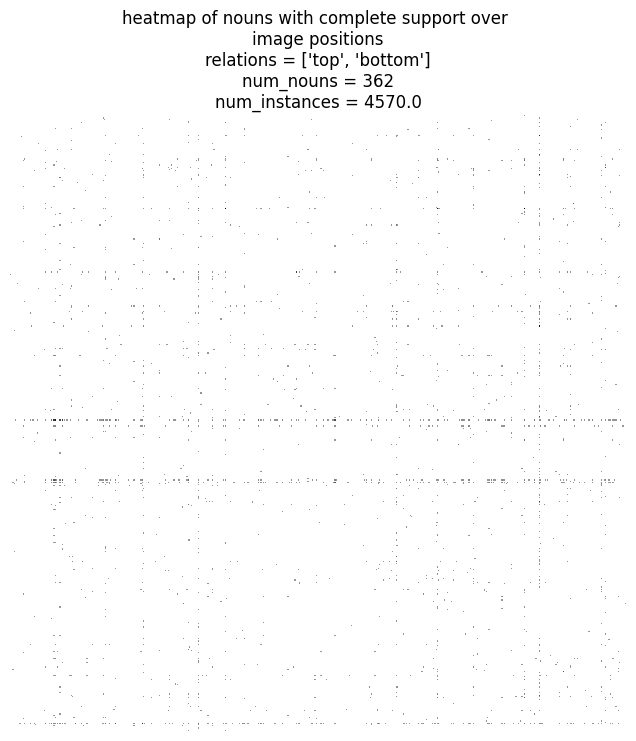

In [155]:

min_y, max_x = 0.3, 80
max_y, min_x = 1, 0.9

plt.figure(figsize=(8,8))
visualize_heatmap = np.zeros((len(both_complete_nouns), len(both_complete_nouns)))
X = []

prefix = "image" if transpose else "linguistic"
for k in alive:
    for l in alive:
        o1, o2 = both_complete_nouns[k], both_complete_nouns[l]        
        x = min(max_x, heatmap[prefix][k][l])
        X.append(x)
        y = 0 if x == 0 else 1/(max_x-min_x) * ((1-min_y)*x + max_x*min_y - min_x)
        visualize_heatmap[k][l] = y
plt.imshow(visualize_heatmap, cmap='binary', interpolation='nearest')
plt.title("heatmap of nouns with complete support over \n{} positions\nrelations = {}\nnum_nouns = {}\nnum_instances = {}"
          .format(
              prefix,
              list(r2i.keys()),
              len(alive),
              sum(X)
        ))
plt.axis("off")
plt.show()

In [46]:
for transpose in [False, True]:
    print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
    SUBJ, OBJ = [], []
    tuples, images, captions = [], [], []
    for unmapped_r in extracted_tuples:
        if not unmapped_r in positional_rel_v: continue
        
        r = map[unmapped_r]

        for a in extracted_tuples[unmapped_r]:
            subj, obj, _ = a[-1]
            #singularize
            singlular_subj = Word(subj).lemmatize()
            if not singlular_subj == False: subj = singlular_subj
            singlular_obj = Word(obj).lemmatize() 
            if not singlular_obj == False: obj = singlular_obj

            if subj in crux_nouns and obj in crux_nouns:
                SUBJ.append(subj)
                OBJ.append(obj)
                tuples.append((subj, obj, r))
                captions.append(a[1])
                images.append(a[0])
    
    nouns = sorted(list(set(SUBJ).union(set(OBJ))))
    num_nouns = len(nouns)
    print("#unique concepts = ", num_nouns)
    num_relations = len(relations)
    print("#instances = ", len(tuples))
    print("#unique instances = ", len(set(tuples)))
    print("#unique images = ", len(set(images)))
    print("#unique captions = ", len(set(captions)))

    train_triplets = [] # convert tuple elements to indices
    n2i = {n:i for i, n in enumerate(nouns)}
    r2i = {r:i for i, r in enumerate(relations)}
    print(len(r2i), len(n2i), "\n")
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    # Sanity check crux_nouns are indeed complete under both linguistic & image positional roles
    print("#unique O1 = ", len(set([t[0] for t in train_triplets])))
    print("#unique O2 = ", len(set([t[1] for t in train_triplets])))
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    for f in entropy_funcs:
        score = eval(f)
        print(f.split("(")[0], ": ", score, f"({round(score/np.log(2), 2)})")  
    print("--------------------------------------------------------\n\n")

role intrinsic meanings: linguistic position

#unique concepts =  369
#instances =  4922
#unique instances =  2049
#unique images =  2176
#unique captions =  4921
2 369 

#unique O1 =  369
#unique O2 =  369
concept_role_index_entropy :  0.32227023349017786 (0.46)
--------------------------------------------------------


role intrinsic meanings: image position

#unique concepts =  369
#instances =  4922
#unique instances =  2049
#unique images =  2176
#unique captions =  4921
2 369 

#unique O1 =  369
#unique O2 =  369
concept_role_index_entropy :  0.33615528651427307 (0.48)
--------------------------------------------------------




In [20]:
if transpose:
    print(len(train_triplets))
    print("train_triplets under {} positional roles:".format("image" if transpose else "linguistic"))
    print(train_triplets)
    print("unique train_triplets = {}".format(len(set(train_triplets))))
print("diagonal supports: ", set([nouns[t[0]] for t in train_triplets if t[0] == t[1]]))

4922
train_triplets under image positional roles:
[(44, 276, 0), (151, 334, 0), (142, 354, 0), (166, 166, 0), (328, 166, 0), (322, 322, 0), (180, 22, 0), (213, 23, 0), (138, 288, 0), (180, 27, 0), (54, 337, 0), (54, 337, 0), (54, 244, 0), (54, 18, 0), (54, 337, 0), (189, 85, 0), (183, 315, 0), (183, 315, 0), (183, 315, 0), (183, 315, 0), (54, 110, 0), (54, 110, 0), (54, 314, 0), (54, 78, 0), (65, 254, 0), (23, 299, 0), (364, 23, 0), (213, 22, 0), (364, 23, 0), (50, 336, 0), (50, 336, 0), (50, 336, 0), (50, 336, 0), (50, 336, 0), (50, 336, 0), (72, 111, 0), (364, 104, 0), (213, 104, 0), (46, 177, 0), (54, 125, 0), (54, 125, 0), (54, 125, 0), (171, 250, 0), (43, 225, 0), (256, 225, 0), (36, 226, 0), (364, 22, 0), (101, 74, 0), (213, 356, 0), (213, 340, 0), (213, 340, 0), (213, 242, 0), (105, 307, 0), (67, 226, 0), (67, 225, 0), (67, 225, 0), (67, 225, 0), (67, 225, 0), (67, 225, 0), (67, 225, 0), (67, 225, 0), (211, 94, 0), (193, 314, 0), (183, 249, 0), (311, 136, 0), (89, 125, 0), (148,